# Abalone dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/abalone(4177, 8).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'abalone'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 3341
of features 8
abalone


## SVM
We train an SVM with RBF kernel for reference.

In [7]:
svm = SVR(C=1e1)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.54522440353871882

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [3]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
cov_params = np.array([1., 10., 1.])

In [7]:
default_plot_interval = [0.42, .56]
def plot_results(it_lst, t_lst, y_lst, clr, label, plot_interval=None):
    if plot_interval is None:
        plot_interval = default_plot_interval
    plt.figure(figsize=(13,5))

    plt.subplot(1, 2, 1)
    plt.plot(it_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Iterations')
    plt.ylabel('r2 score on test-set')

    plt.subplot(1, 2, 2)
    plt.plot(t_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Time(s)')
    plt.ylabel('r2 score on test-set')

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [5]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [6]:
opts = {'maxiter': 150}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [8]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'it', freq=1)

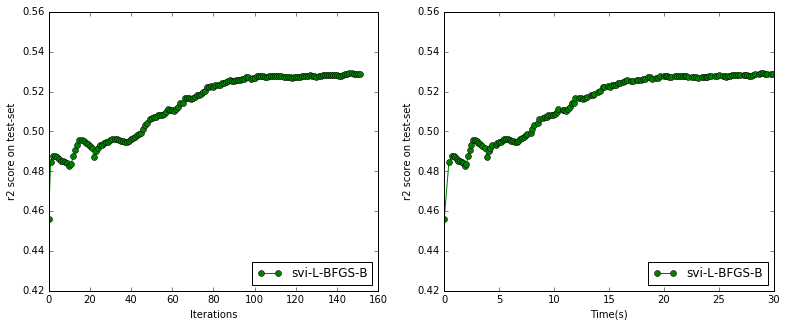

In [9]:
plot_results(lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst, '-go', 'svi-L-BFGS-B')

In [10]:
lbfgs_svi_y_lst[-1]

0.52865160855531079

In [12]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xi.npy', lbfgs_svi_xi_lst)
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xt.npy', lbfgs_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [13]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [14]:
opts = {'maxiter': 20, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Warning, matrix is not positive definite [  1.37979249e+01   1.12973430e+01   1.00000000e-02]


In [15]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_xi_lst, vi_xt_lst, vi_y_lst = vi_res.plot_performance(metric, 'it', freq=1)

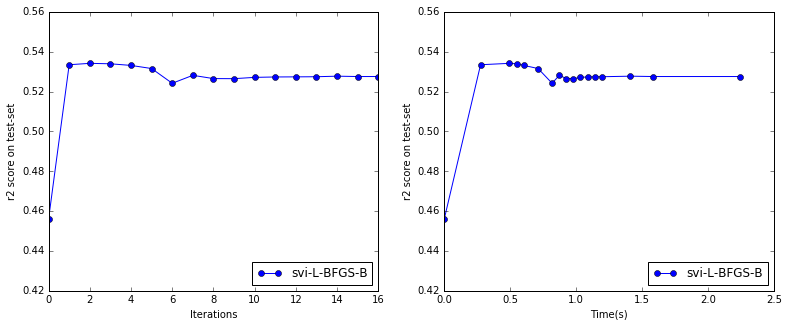

In [16]:
plot_results(vi_xi_lst, vi_xt_lst, vi_y_lst, '-bo', 'svi-L-BFGS-B')

In [17]:
vi_y_lst[-1]

0.52751892030842384

In [18]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xi.npy', vi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xt.npy', vi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [19]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [20]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': 1.1,
                'maxiter': 500, 'batch_size':200}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Using AdaDelta optimizer
Iteration  49 :
	Gradient norm 0.616069999917
Iteration  99 :
	Gradient norm 0.0343777123056
Iteration  149 :
	Gradient norm 0.503291201052
Iteration  199 :
	Gradient norm 0.0918956951416
Iteration  249 :
	Gradient norm 0.221692975373
Iteration  299 :
	Gradient norm 0.229607032537
Iteration  349 :
	Gradient norm 0.463609832377
Iteration  399 :
	Gradient norm 0.320524098301
Iteration  449 :
	Gradient norm 0.448845028341
Iteration  499 :
	Gradient norm 0.527932364038


In [21]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'it', freq=5)

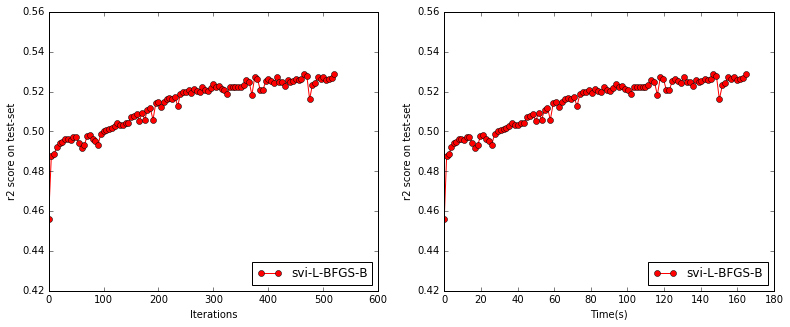

In [22]:
plot_results(ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst, '-ro', 'svi-L-BFGS-B')

In [23]:
ad_svi_y_lst[-1]

0.52870797764352084

In [24]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xi.npy', ad_svi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xt.npy', ad_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)

###SG-cholesky
Stochastic gradient descent.

In [85]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SG')

In [86]:
opts = {'maxiter':2000, 'batch_size': 200 , 'print_freq': 10, 'step0': 7e-1, 'gamma': .2}
sg_svi_res = sg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.7
	Parameters [  0.91094909  10.02756176]
Epoch  10 :
	Step: 0.441670141136
	Parameters [  1.27573591  10.12879526]
Epoch  20 :
	Step: 0.384496190157
	Parameters [  1.36630228  10.19652039]
Epoch  30 :
	Step: 0.354546978878
	Parameters [  1.37007544  10.27811549]
Epoch  40 :
	Step: 0.334723374927
	Parameters [  1.49491076  10.32266467]
Epoch  50 :
	Step: 0.320113536349
	Parameters [  1.54528087  10.37760791]
Epoch  60 :
	Step: 0.308651072178
	Parameters [  1.6176572   10.41820801]
Epoch  70 :
	Step: 0.299280507757
	Parameters [  1.57688971  10.47399259]
Epoch  80 :
	Step: 0.291393622591
	Parameters [  1.6105383   10.52062086]
Epoch  90 :
	Step: 0.284609595542
	Parameters [  1.68707711  10.55181921]
Epoch  100 :
	Step: 0.278675019387
	Parameters [  1.6313523   10.60237037]
Epoch  110 :
	Step: 0.273413215818
	Parameters [  1.67830793  10.63386464]
Epoch  120 :
	Step: 0.268696364746
	Parameters [  1.7288281   10.66276004]
Epoch  130 :
	Step: 0.264429174706
	Parameters 

In [87]:
metric = lambda w: sg_svi_gp.get_prediction_quality(w, x_test, y_test)
sg_svi_x_lst, sg_svi_y_lst = sg_svi_res.plot_performance(metric, 'i', freq=5)

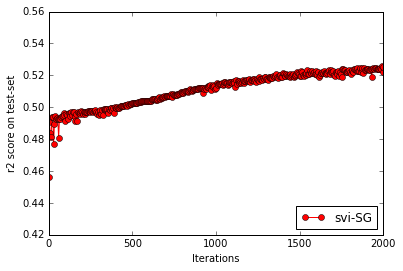

In [88]:
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.ylim([.42, .56])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [89]:
sg_svi_y_lst[-1]

0.52514043671385502

In [90]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_x.npy', sg_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_y.npy', sg_svi_y_lst)

### SG-Natural
Stochastic gradient descent with natural gradients with respect to the variational parameters.

In [133]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [134]:
opts = {'maxiter':5000, 'batch_size': 200 , 'print_freq': 50, 'step0': 5e-1, 'gamma': 0.05}
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.5
	Parameters [ 1.16743777  9.99991163]
Epoch  50 :
	Step: 0.411170079713
	Parameters [  1.30493311  10.58261704]
Epoch  100 :
	Step: 0.397164117362
	Parameters [  1.51818961  10.98603356]
Epoch  150 :
	Step: 0.389193377198
	Parameters [  1.52394745  11.3186675 ]
Epoch  200 :
	Step: 0.383635249505
	Parameters [  1.74179649  11.56230187]
Epoch  250 :
	Step: 0.379378752309
	Parameters [  1.83661423  11.77013658]
Epoch  300 :
	Step: 0.375936022012
	Parameters [  1.81954196  11.968471  ]
Epoch  350 :
	Step: 0.373049620153
	Parameters [  1.89583795  12.1146309 ]
Epoch  400 :
	Step: 0.370567224553
	Parameters [  1.99212573  12.2480219 ]
Epoch  450 :
	Step: 0.368391311353
	Parameters [  2.02328734  12.36088045]
Epoch  500 :
	Step: 0.366455719277
	Parameters [  2.15107684  12.46177944]
Epoch  550 :
	Step: 0.364713525769
	Parameters [  2.16131883  12.56354812]
Epoch  600 :
	Step: 0.363130261013
	Parameters [  2.22489144  12.65074431]
Epoch  650 :
	Step: 0.361679868816
	Param

In [135]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

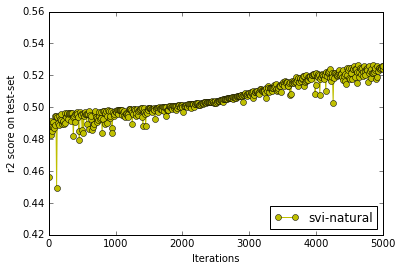

In [136]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.42, .56])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [137]:
sng_svi_y_lst[-1]

0.52578784521600763

In [138]:
np.max(sng_svi_y_lst)

0.52637180780315185

In [139]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_x.npy', sng_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_y.npy', sng_svi_y_lst)

### SG-Natural-ss
This method uses natural gradients for svi wrt variational parameters as svi-natural does. But this method chooses separate step-length for the to types of parameters it optimizes.

In [27]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ss_sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [28]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .5,
                'maxiter': 1000, 'batch_size': 300, 'nat_mult': 10.}
ss_sng_svi_res = ss_sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

10.0
Using SG optimizer
Iteration  49 :
	Gradient norm 0.609018957092
Iteration  99 :
	Gradient norm 0.728754766784
Iteration  149 :
	Gradient norm 0.944635243346
Iteration  199 :
	Gradient norm 0.916815338918
Iteration  249 :
	Gradient norm 0.443486045215
Iteration  299 :
	Gradient norm 0.407221664908
Iteration  349 :
	Gradient norm 0.980680114267
Iteration  399 :
	Gradient norm 1.06757820802
Iteration  449 :
	Gradient norm 1.26015937912
Iteration  499 :
	Gradient norm 3.51199805797
Iteration  549 :
	Gradient norm 0.871497170631
Iteration  599 :
	Gradient norm 0.752636930162
Iteration  649 :
	Gradient norm 1.0733469416
Iteration  698 :
	Gradient norm 0.420054953734
Iteration  748 :
	Gradient norm 1.50129446528
Iteration  798 :
	Gradient norm 1.18404302127
Iteration  848 :
	Gradient norm 0.611420937116
Iteration  898 :
	Gradient norm 1.46310639765
Iteration  948 :
	Gradient norm 0.784948355691
Iteration  998 :
	Gradient norm 0.70181497344


In [29]:
metric = lambda w: ss_sng_svi_gp.get_prediction_quality(w, x_test, y_test)
ss_sng_svi_x_lst, ss_sng_svi_y_lst = ss_sng_svi_res.plot_performance(metric, 'i', freq=10)

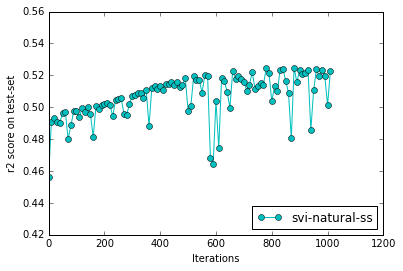

In [30]:
plt.plot(ss_sng_svi_x_lst, ss_sng_svi_y_lst, '-co', label='svi-natural-ss')
plt.ylim([.42, .56])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [ ]:
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_x.npy', ss_sng_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_y.npy', ss_sng_svi_y_lst)